# LangGraph

## 사전 준비 : 가상 환경 구축, 패키지 설치

In [1]:
#1

!pip uninstall -y google-generativeai
!pip install langchain==0.3.20 langchain_core==0.3.49 langchain_google_genai==2.1.1 httpx==0.28.1 requests==2.32.3 langgraph==0.3.8

Found existing installation: google-generativeai 0.8.5
Uninstalling google-generativeai-0.8.5:
  Successfully uninstalled google-generativeai-0.8.5
INFO: pip is looking at multiple versions of langchain-text-splitters to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.1/420.1 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.6/133.6 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 14

## 대화 이력을 유지하는 방법

In [2]:
#2

import os

#환경 변수와 패키지 준비
from google.colab import userdata
os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")
#os.environ["GOOGLE_API_KEY"] = "***"

import operator
from typing import TypedDict, Annotated

from langchain_google_genai import ChatGoogleGenerativeAI

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage, SystemMessage, AnyMessage


from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, END, StateGraph



In [3]:
#3

# gemini 모델 정의
model = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0
)

# message 작성
message = [
    SystemMessage(content= "당신은 한국어를 말하는 우수한 어시스턴트입니다. 회답에는 반드시 한국어로 대답해 주세요. 또 생각하는 과정도 출력해 주세요."),
    MessagesPlaceholder("messages"),
]

# message 프롬프트 작성
prompt = ChatPromptTemplate.from_messages(message)

#chain 정의
chain = prompt | model

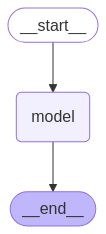

In [4]:
#4

class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

def create_langgraph(chain):

    def call_llm(state: GraphState):
        response = chain.invoke({"messages":state["messages"]})
        return {"messages": [response]}

    workflow = StateGraph(state_schema=GraphState)
    workflow.add_node("model", call_llm)

    workflow.add_edge(START, "model")
    workflow.add_edge("model", END)

    memory = MemorySaver()
    graph = workflow.compile(checkpointer=memory)
    return graph

graph = create_langgraph(chain)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
#5

while True:
    query = input("질문을 입력하세요: ")

    if query.lower() in ["exit", "quit"]:
        print("종료합니다.")
        break

    print("################# 질문 #################")
    print("질문:", query)

    input_query = [HumanMessage(
            [
                {
                    "type": "text",
                    "text": f"{query}"
                },
            ]
        )]

    response = graph.invoke({"messages": input_query} ,config={"configurable": {"thread_id": "12345"}})

    print("################# 응답 #################")
    print("AI 응답",response["messages"][-1].content)




질문을 입력하세요: 당신은 개발자의 비전에 대해 어떻게 생각하세요?
################# 질문 #################
질문: 당신은 개발자의 비전에 대해 어떻게 생각하세요?
################# 응답 #################
AI 응답 개발자의 비전에 대한 저의 생각을 다시 한번 정리해서 말씀드리겠습니다.

**핵심 요약:** 저는 개발자의 비전이 매우 중요하다고 생각하며, 긍정적인 사회 변화를 이끌어내는 데 핵심적인 역할을 한다고 믿습니다.

**상세 내용:**

1.  **비전의 중요성:**
    *   **방향성 제시:** 개발자가 어떤 기술을 배우고 어떤 프로젝트에 집중해야 할지 명확한 방향을 제시합니다.
    *   **동기 부여:** 어려운 문제에 직면했을 때 포기하지 않고 해결책을 찾도록 강력한 동기를 부여합니다.
    *   **혁신 촉진:** 기존의 틀을 깨고 새로운 아이디어를 탐구하며 혁신적인 솔루션을 개발하도록 장려합니다.
    *   **가치 창출:** 단순히 코드를 작성하는 것을 넘어, 기술을 통해 사회에 긍정적인 영향을 미치고 가치를 창출하도록 이끕니다.

2.  **바람직한 비전의 특징:**
    *   **사회적 책임감:** 환경 문제 해결, 교육 기회 확대, 의료 서비스 개선 등 사회 문제 해결에 기여하려는 의지를 담아야 합니다.
    *   **사용자 중심:** 사용자의 요구를 깊이 이해하고, 사용자의 삶을 더 편리하고 풍요롭게 만들 수 있는 솔루션을 제공해야 합니다.
    *   **지속 가능성:** 장기적인 관점에서 기술 발전과 사회 발전을 조화롭게 추구해야 합니다.
    *   **윤리적 고려:** 기술의 오남용을 방지하고, 개인 정보 보호 및 데이터 보안과 같은 윤리적 문제를 중요하게 고려해야 합니다.

3.  **비전의 예시:**
    *   인공지능을 활용하여 질병 예측 및 진단 정확도를 높여 더 많은 사람들의 건강한 삶에 기여한다.
    *   블록체인 기술을 